<a href="https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Download Dataset

In [2]:
#!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

In [10]:
# в данном проекте уже скачан данный файл
#!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

## Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

training_set:  [[112]
 [118]
 [132]
 [129]
 [121]]
weekend_set:  [[11]
 [ 9]
 [ 8]
 [ 9]
 [ 9]]


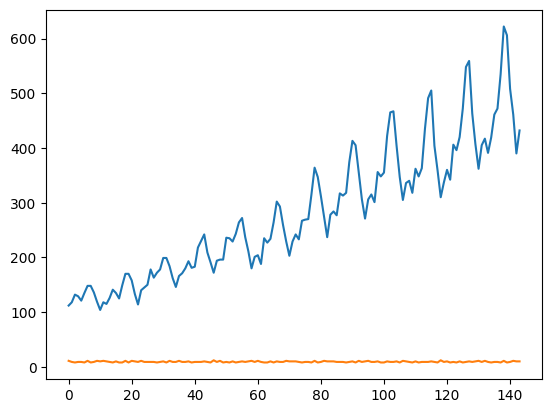

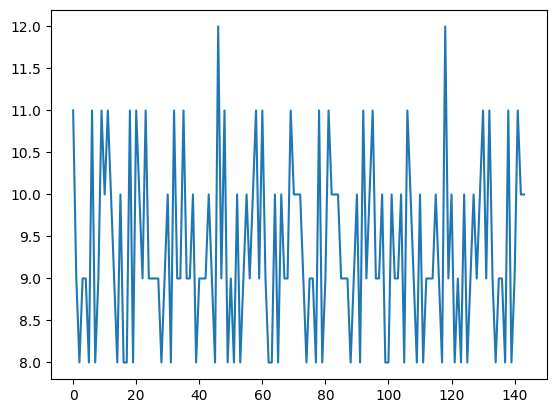

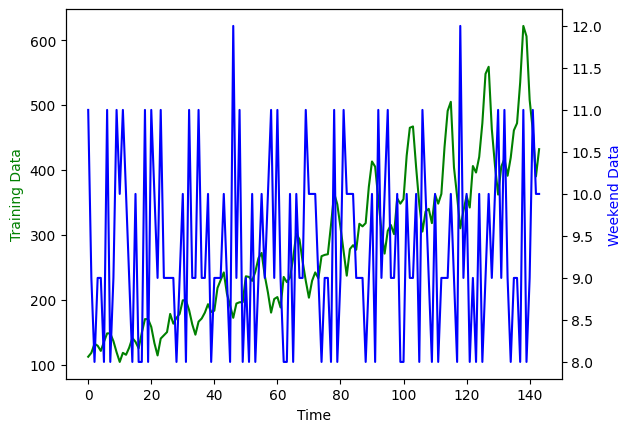

In [33]:
training_full_set = pd.read_csv('airline-passengers-weekend.csv')
#training_set = pd.read_csv('shampoo.csv')
# print(training_set)

training_set = training_full_set.iloc[:,1:2].values.reshape(-1, 1)
weekend_set = training_full_set.iloc[:, 2].values.reshape(-1, 1)

print('training_set: ', training_set[:5])
print('weekend_set: ', weekend_set[:5])


#plt.plot(training_set, label = 'Shampoo Sales Data')
""" 
график 
по оси X количество пассажиров и количество праздников
по оси Y номер месяца от января 1949 года 
"""
plt.plot(training_set, label = 'Airline Passangers Data')
plt.plot(weekend_set, label = 'Airline Passangers Data')
plt.show()

""" 
график 
по оси X количество праздников
по оси Y номер месяца от января 1949 года 
"""
plt.plot(weekend_set, label = 'Airline Passangers Data')
plt.show()

""" 
график 
по оси X слева количество пассажиров
по оси X справа количество праздников
по оси Y номер месяца от января 1949 года 
"""
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(training_set, color='g')
ax2.plot(weekend_set, color='b')
ax1.set_xlabel('Time')
ax1.set_ylabel('Training Data', color='g')
ax2.set_ylabel('Weekend Data', color='b')
plt.show()


## Dataloading

In [52]:
""" 
data1 - passagers
data2 - weekend
"""
def sliding_windows(data1, data2, seq_length):
    x1 = []
    x2 = []
    y = []

    for i in range(len(data1)-seq_length-1):
        _x1 = data1[i:(i+seq_length)]
        _x2 = data2[i:(i+seq_length)]
        _y = data1[i+seq_length]
        x1.append(_x1)
        x2.append(_x2)
        y.append(_y)

    return np.array(x1), np.array(x2), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

print('training_data: ', training_data[:5])

weekend_data = sc.fit_transform(weekend_set)

print('weekend_data: ', weekend_data[:5])


""" 
In originals: 
seq_length = 4

мне больше нравится 60
seq_length = 60
"""
seq_length = 5
x1, x2, y = sliding_windows(training_data, weekend_data, seq_length)

print('x1: ', x1[:1])
print('x2: ', x2[:1])
print('y: ', y[:1])

""" 
In originals:
train_size = int(len(y) * 0.67)
"""
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX1 = Variable(torch.Tensor(np.array(x1)))
dataX2 = Variable(torch.Tensor(np.array(x2)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX1 = Variable(torch.Tensor(np.array(x1[0:train_size])))
trainX2 = Variable(torch.Tensor(np.array(x2[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX1 = Variable(torch.Tensor(np.array(x1[train_size:len(x1)])))
testX2 = Variable(torch.Tensor(np.array(x2[train_size:len(x2)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

training_data:  [[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]
weekend_data:  [[0.75]
 [0.25]
 [0.  ]
 [0.25]
 [0.25]]
x1:  [[[0.01544402]
  [0.02702703]
  [0.05405405]
  [0.04826255]
  [0.03281853]]]
x2:  [[[0.75]
  [0.25]
  [0.  ]
  [0.25]
  [0.25]]]
y:  [[0.05984556]]


## Model

In [70]:
"""
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        print('num cl: ', num_classes)
        print('num l: ', num_layers)
        print('in size: ', input_size)
        print('hi size: ', hidden_size)
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out
"""
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size1, input_size2, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size1 = input_size1
        self.input_size2 = input_size2
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size1 + input_size2, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out


## Training

In [72]:
num_epochs = 2000
learning_rate = 0.01

""" 
In originals: 

num_classes = 1
num_layers = 1
input_size = 1
hidden_size = 2
"""
num_classes = 1
num_layers = 1
input_size1 = 1
input_size2 = 1
hidden_size = 2

lstm = LSTM(num_classes, input_size1, input_size2, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    trainX1 = torch.unsqueeze(trainX1, 2)
    trainX2 = torch.unsqueeze(trainX2, 2)
    trainX = torch.cat((trainX1, trainX2), dim=2)
    outputs = lstm(trainX)
    # outputs = lstm(trainX1, trainX2)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

num cl:  1
num l:  1
in size1:  1
in size2:  1
hi size:  2


RuntimeError: input.size(-1) must be equal to input_size. Expected 2, got 1

## Testing for Airplane Passengers Dataset

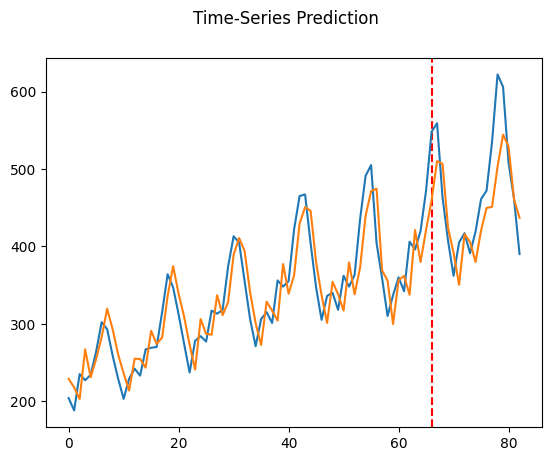

In [32]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()